In [1]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching
    

import torch
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

In [17]:
cfg = breaching.get_config(overrides=["case=PJ_image_custom", "attack=PJ_DLG"])
cfg.seed = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case image_custom with server type honest_but_curious.


{'device': device(type='cuda', index=0), 'dtype': torch.float32}

### Instantiate all parties

In [18]:
import copy
import pickle
import numpy as np
from omegaconf import open_dict
with open_dict(cfg):
    cfg.case.data.vocab_size = 100 # issue if not setup

num_trials = 1
mask_dict = {
    "mask_percentage_in_channels": [{"p": float(p)} for p in np.linspace(0.1, 0.9, 9)],
}
# mask_list = ["mask_fixed_identity", "mask_fixed_bernoulli", "mask_fixed_layer", "mask_clip"]

# p_bernoulli = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# clip_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
p_bernoulli = None
clip_values = None
percentage_values = None
results = {mask_fn: {} for mask_fn, _ in mask_dict.items()}
results["images_saved"] = {}
run_exp = False
def get_setup(cfg, setup):
    user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
    attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
    server_payload = server.distribute_payload()
    shared_data, true_user_data = user.compute_local_updates(server_payload)
    return user, server, model, loss_fn, attacker, server_payload, shared_data, true_user_data
def main(cfg, setup):
    user, server, model, loss_fn, attacker, server_payload, shared_data, true_user_data = get_setup(cfg, setup)
    reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], {}, dryrun=cfg.dryrun)
    metrics = breaching.analysis.report(
        reconstructed_user_data, 
        true_user_data,
        [server_payload], 
        server.model,
        order_batch=True,
        compute_full_iip=False, 
        cfg_case=cfg.case,
        setup=setup,
    )
    return metrics, reconstructed_user_data, true_user_data
def main_dict(mask_dict, cfg):
    results["cfg"] = copy.deepcopy(cfg)
    results["mask_dict"] = copy.deepcopy(mask_dict)
    for mask_fn, mask_cfgs in mask_dict.items():
        run_number = 0
        results["images_saved"][mask_fn] = {}
        for mask_cfg in mask_cfgs:
            cfg = copy.deepcopy(results["cfg"]) # reset to initial config
            with open_dict(cfg):
                cfg.attack.objective.mask_fn = mask_fn
                for key, value in mask_cfg.items():
                    cfg.attack.objective[key] = value
            results[mask_fn][run_number] = {}
            results[mask_fn][run_number]["mask_cfg"] = mask_cfg
            for trial in range(num_trials):
                logging.info(f"mask_fn: {mask_fn} | mask_cfg: {mask_cfg} | trial: {trial}")
                metrics, reconstructed_user_data, true_user_data = main(cfg, setup)
                results[mask_fn][run_number][trial] = metrics
            run_number += 1
            results["images_saved"][mask_fn][run_number] = {}
            results["images_saved"][mask_fn][run_number]["metrics"] = metrics
            results["images_saved"][mask_fn][run_number]["reconstructed_user_data"] = reconstructed_user_data
            results["images_saved"][mask_fn][run_number]["true_user_data"] = true_user_data

    save_path = "./testing/results_mask_percentage_redo.pickle"
    with open(save_path, 'wb') as file:
        pickle.dump(results, file, protocol=pickle.HIGHEST_PROTOCOL)
if run_exp:
    main_dict(mask_dict, cfg)

In [136]:
mse_mean = 0
mse_var = 0
n = 30
for i in range(n):
    mse_mean += results["mask_clip"]["0.1"][i]["mse"]
mse_mean /= n

for i in range(n):
    mse_var += (results["mask_clip"]["0.1"][i]["mse"] - mse_mean)**2
mse_var /= n

print(mse_mean)
print(n * mse_var / (n-1))

0.1125494360923767
0.0004039836067923969


### Simulate an attacked FL protocol

In [2]:
import pickle

save_path = "./testing/results_mask_percentage.pickle"

with open(save_path, 'rb') as file:
    saved_dico = pickle.load(file)
print(saved_dico.keys())

dict_keys(['mask_percentage_in_channels', 'images_saved', 'cfg', 'mask_dict'])


In [3]:
import pickle

save_path = "./testing/results_mask_percentage_redo.pickle"

with open(save_path, 'rb') as file:
    saved_dico_redo = pickle.load(file)
print(saved_dico_redo.keys())

dict_keys(['mask_percentage_in_channels', 'images_saved', 'cfg', 'mask_dict'])


In [4]:
saved_dico["images_saved"].update(saved_dico_redo["images_saved"])

In [5]:
import copy

def average_metrics_trials(metrics, num_trials=None):
    if num_trials is None:
        num_trials = len(metrics.keys()) - 1
    res_dico = {}
    for i in range(num_trials):
        for key in metrics[i].keys():
            if key == "mask_cfg":
                continue
            elif key in res_dico:
                res_dico[key] += metrics[i][key]
            else:
                res_dico[key] = copy.deepcopy(metrics[i][key])
    for key in res_dico.keys():
        if key != "order":
            res_dico[key] /= num_trials
    return res_dico

def summarize_score_trials(metrics):
    average_dico = {}
    for key1 in metrics.keys():
        if "mask" in key1 and key1 != "mask_dict":
            average_dico[key1] = {}
            simpler_metrics = []
            for key2 in metrics[key1].keys():
                if key2 in range(10):
                    average_dico[key1][key2] = average_metrics_trials(metrics[key1][key2])
                else:
                    simpler_metrics.append(metrics[key1][key2])
            print(simpler_metrics)
            if simpler_metrics != []:
                average_dico[key1]["avg"] = breaching.utils.avg_n_dicts(simpler_metrics)
    return average_dico

average_dico = summarize_score_trials(saved_dico)

[]


In [6]:
print(average_dico['mask_percentage_in_channels'].keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])


In [7]:
def extract_one_metric(average_dico, key):
    res_key = []
    for key1 in average_dico.keys():
        if "mask" in key1 and key1 != "mask_dict":
            for key2 in average_dico[key1].keys():
                if not (key1 == "mask_fixed_bernoulli" and key2 == "avg"):
                    res_key.append(average_dico[key1][key2][key])
    return res_key

print(tuple(extract_one_metric(average_dico, "mse")))

(0.0944045264273882, 0.05925831533968449, 0.045766410604119304, 0.031878887116909026, 0.02310704356059432, 0.01948196440935135, 0.012730900337919593, 0.01162591613829136, 0.012271153600886464)


In [143]:
a = [654,55,654,8,7,54,87,2,54,3,9,1,1]
print([a[i] for i in range(1, 10)])

[55, 654, 8, 7, 54, 87, 2, 54, 3]


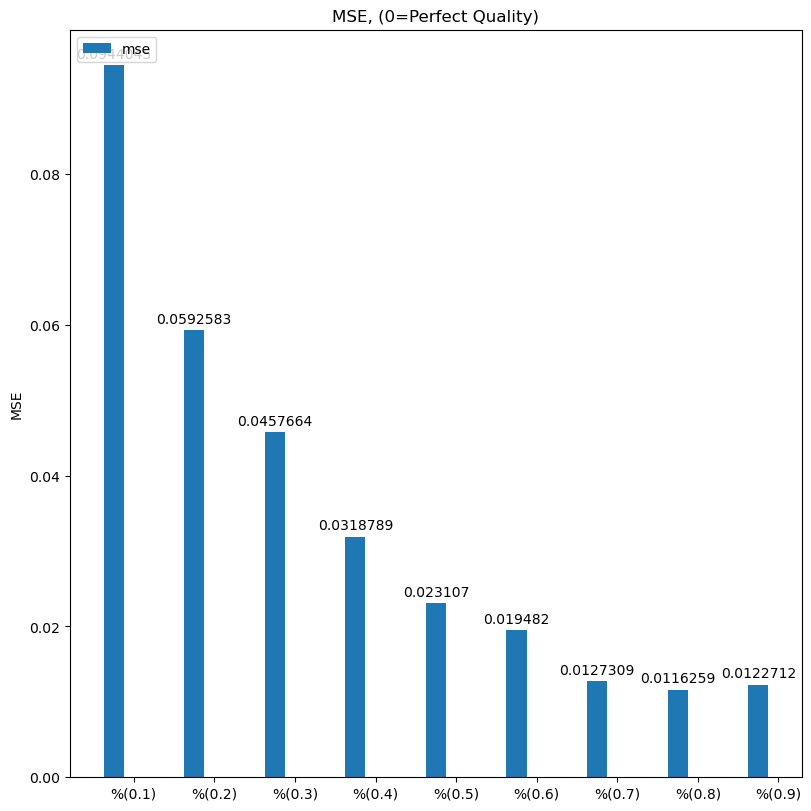

In [8]:
import matplotlib.pyplot as plt
import numpy as np

"dict_keys(['mse', 'psnr', 'lpips', 'rpsnr', 'ssim', 'max_ssim', 'max_rpsnr', 'order', 'IIP-pixel', 'feat_mse', 'parameters', 'label_acc'])"

_slice_bernoulli = range(1, 1+9)
_slice_clip = range(11, 11+9)
_slice_percentage  = range(20, 20+9)
_slice_mean = [0, 5, 10, 15]


_slice = _slice_percentage
species = (
    ("Identity",) 
    + ("Ber(0.1)", "Ber(0.2)", "Ber(0.3)", "Ber(0.4)", "Ber(0.5)", "Ber(0.6)", "Ber(0.7)", "Ber(0.8)", "Ber(0.9)")
    + ("1 Fixed Layer",) 
    + ("Clip(0.1)", "Clip(0.2)", "Clip(0.3)", "Clip(0.4)", "Clip(0.5)", "Clip(0.6)", "Clip(0.7)", "Clip(0.8)", "Clip(0.9)")
    + ("%(0.1)", "%(0.2)", "%(0.3)", "%(0.4)", "%(0.5)", "%(0.6)", "%(0.7)", "%(0.8)", "%(0.9)")
)
species = [species[i] for i in _slice]

penguin_means = {
    'mse': tuple(extract_one_metric(average_dico, "mse")),
    # 'psnr': tuple(extract_one_metric(average_dico, "psnr")),
    # 'lpips': tuple(extract_one_metric(average_dico, "lpips")),
    # 'rpsnr': tuple(extract_one_metric(average_dico, "rpsnr")),
    # 'ssim': tuple(extract_one_metric(average_dico, "ssim")),
    # 'max_ssim': tuple(extract_one_metric(average_dico, "max_ssim")),
    # 'max_rpsnr': tuple(extract_one_metric(average_dico, "max_rpsnr")),
    # 'IIP-pixel': tuple(extract_one_metric(average_dico, "IIP-pixel")),
    # 'feat_mse': tuple(extract_one_metric(average_dico, "feat_mse")),
}
# for key in penguin_means.keys():
#     penguin_means[key] = [penguin_means[key][i] for i in _slice]
# species = ("Ber(0.1)", "Ber(0.2)", "Ber(0.3)", "Ber(0.4)", "Ber(0.5)", "Ber(0.6)", "Ber(0.7)", "Ber(0.8)", "Ber(0.9)")

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(8, 8))

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

if "psnr" in penguin_means.keys():
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('dB')
    ax.set_title('PSNR for different mask')
    ax.set_xticks(x + width, species)
    ax.legend(loc='upper left', ncols=3)
    # ax.set_ylim(0,1.1)

if "ssim" in penguin_means.keys():
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('SSIM')
    ax.set_title('SSIM for different masks (1=Perfect Quality)')
    ax.set_xticks(x + width, species)
    ax.legend(loc='upper left', ncols=3)
    # ax.set_ylim(0,1.1)

if "mse" in penguin_means.keys():
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('MSE')
    ax.set_title('MSE, (0=Perfect Quality)')
    ax.set_xticks(x + width, species)
    ax.legend(loc='upper left', ncols=3)
    # ax.set_ylim(0,1.1)

plt.show()

In [16]:
print(saved_dico["images_saved"]['mask_percentage_in_channels'].keys())
print(saved_dico["images_saved"]['mask_percentage_in_channels'][1].keys())

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])
dict_keys(['metrics', 'reconstructed_user_data', 'true_user_data'])


In [24]:
metrics[exp].keys()

dict_keys(['mse', 'psnr', 'lpips', 'rpsnr', 'ssim', 'max_ssim', 'max_rpsnr', 'order', 'IIP-pixel', 'feat_mse', 'parameters', 'label_acc'])

Files already downloaded and verified
self.cfg.objective.type: Masked-euclidean
Computing user update on user 0 in model mode: eval.


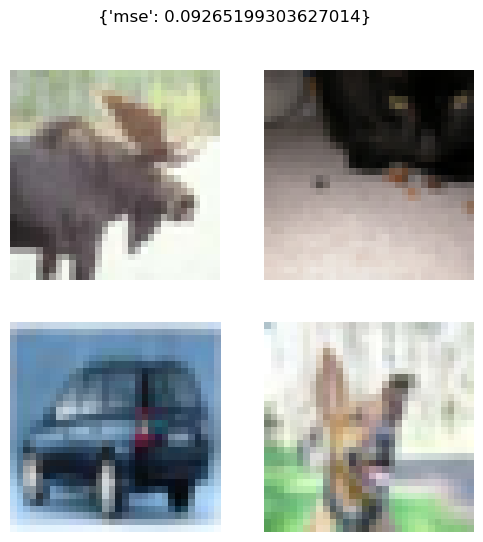

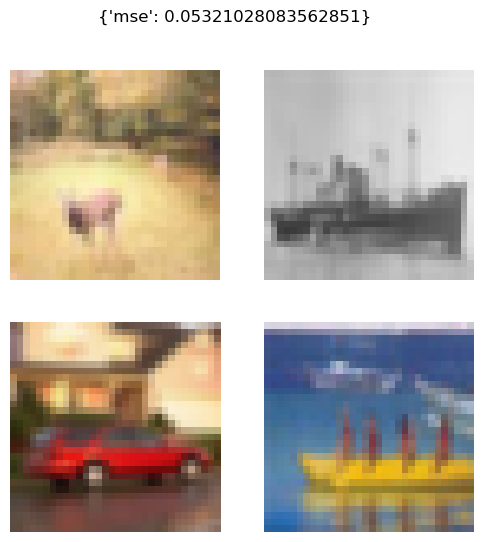

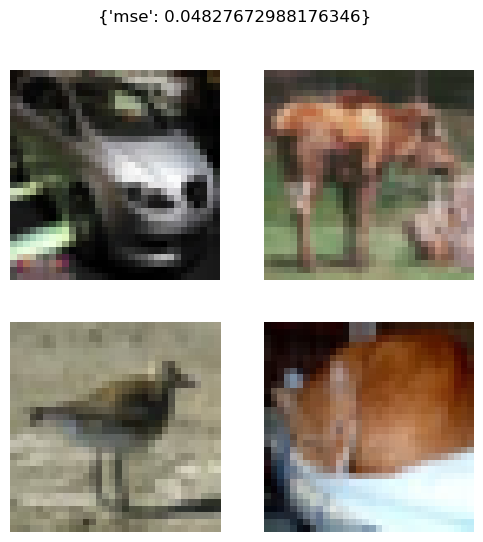

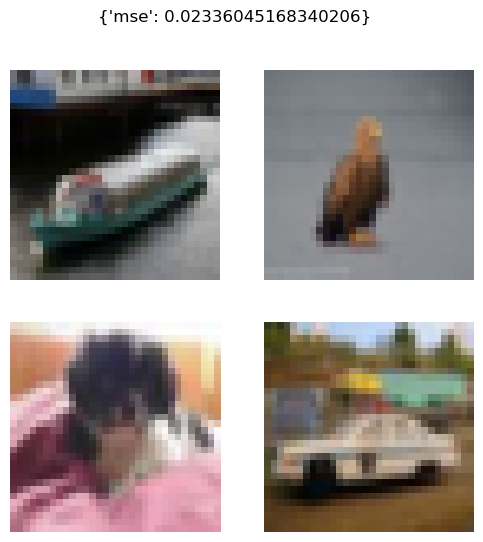

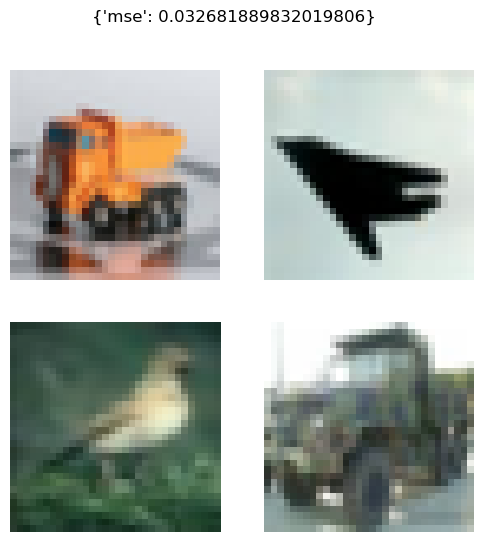

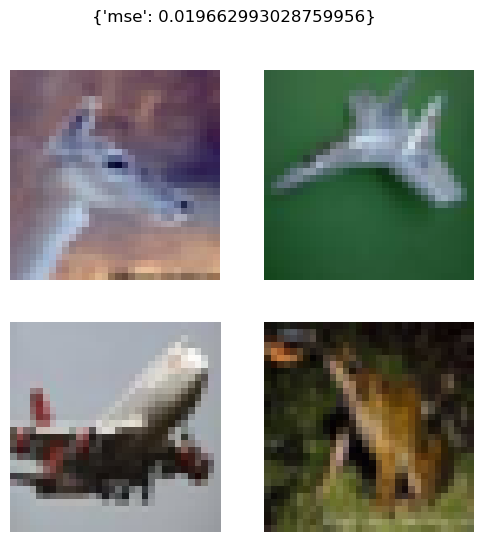

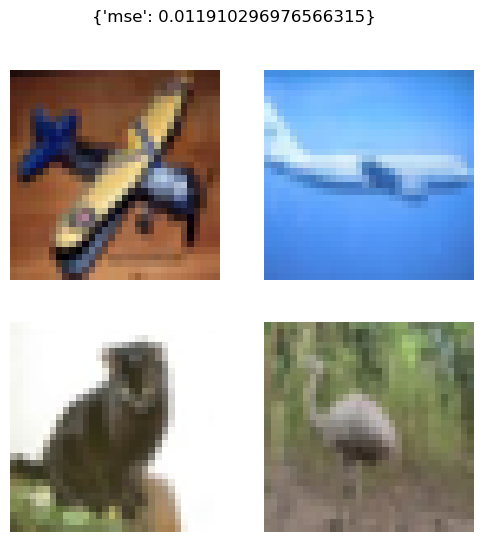

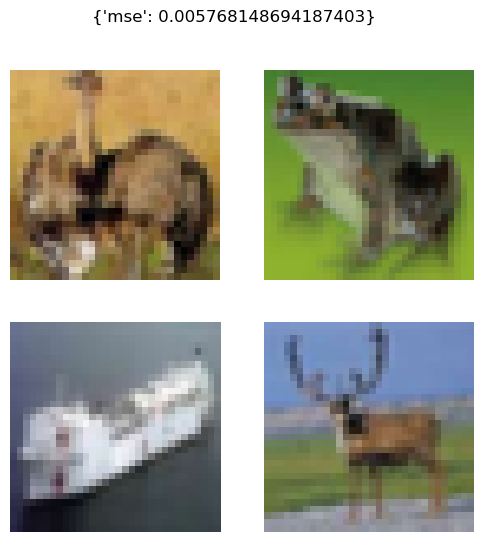

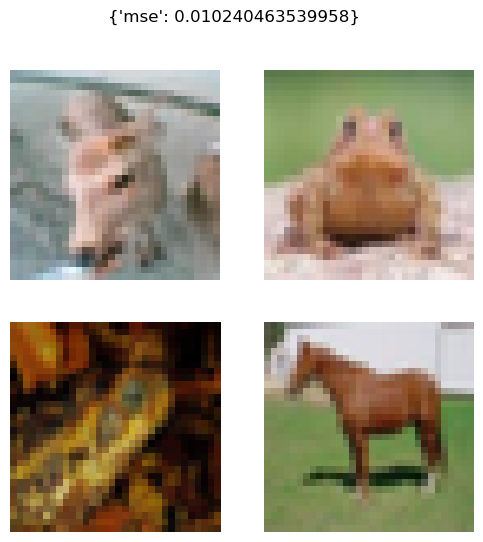

In [30]:
def get_user_and_rec_data(saved_dico, mask_fn):
    metrics = {}
    user_data = {}
    rec_data = {}
    for exp in saved_dico["images_saved"][mask_fn].keys():
        metrics[exp] = saved_dico["images_saved"][mask_fn][exp]['metrics']
        rec_data[exp] = saved_dico["images_saved"][mask_fn][exp]['reconstructed_user_data']
        user_data[exp] = saved_dico["images_saved"][mask_fn][exp]['true_user_data']
    return metrics, rec_data, user_data

with open_dict(cfg):
    cfg.attack.objective.mask_fn = "mask_percentage_in_channels"
    cfg.attack.objective.p = 0.5
user, server, model, loss_fn, attacker, server_payload, shared_data, true_user_data = get_setup(cfg, setup)
dm = torch.as_tensor(user.dataloader.dataset.mean, **user.setup)[None, :, None, None]
ds = torch.as_tensor(user.dataloader.dataset.std, **user.setup)[None, :, None, None]
classes = user.dataloader.dataset.classes

scale = False
print_labels = False
metrics, rec_data, user_data = get_user_and_rec_data(saved_dico, "mask_percentage_in_channels")
metrics_to_extract = ["mse"]
for exp in range(1,10):
    data = user_data[exp]["data"].clone().detach()
    labels = user_data[exp]["labels"].clone().detach() if user_data[exp]["labels"] is not None else None
    metric = {}
    for metric_ in metrics_to_extract:
        metric[metric_] = metrics[exp][metric_]
    if labels is None:
        print_labels = False

    if scale:
        min_val, max_val = data.amin(dim=[2, 3], keepdim=True), data.amax(dim=[2, 3], keepdim=True)
        # print(f'min_val: {min_val} | max_val: {max_val}')
        data = (data - min_val) / (max_val - min_val)
    else:
        data.mul_(ds).add_(dm).clamp_(0, 1)
    data = data.to(dtype=torch.float32)

    if data.shape[0] == 1:
        plt.axis("off")
        plt.imshow(data[0].permute(1, 2, 0).cpu())
        if print_labels:
            plt.title(f"Data with label {classes[labels]}")
    else:
        grid_shape = int(torch.as_tensor(data.shape[0]).sqrt().ceil())
        s = 24 if data.shape[3] > 150 else 6
        fig, axes = plt.subplots(grid_shape, grid_shape, figsize=(s, s))
        label_classes = []
        for i, (im, axis) in enumerate(zip(data, axes.flatten())):
            axis.imshow(im.permute(1, 2, 0).cpu())
            if labels is not None and print_labels:
                label_classes.append(classes[labels[i]])
            axis.axis("off")
        fig.suptitle(str(metric))
        if print_labels:
            print(label_classes)
        plt.show()

In [19]:
# import pickle

# dict_to_save = {
#     "reconstructed_user_data": reconstructed_user_data,
#     "true_user_data": true_user_data,
#     "server_payload": server_payload,
#     "server.model": server.model,
#     "cfg": cfg,
#     "setup": setup,
#     "metrics": metrics,
# }

# save_path = "./outputs/default/2023-02-15/13-27-57/results.pickle"

# with open(save_path, 'wb') as file:
#     pickle.dump(dict_to_save, file, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
# import pickle
# save_path = "./outputs/default/2023-02-15/13-27-57/results.pickle"
# with open(save_path, "rb") as file:
#     result = pickle.load(file)
#     reconstructed_user_data = result["reconstructed_user_data"]

And finally, we also plot the reconstructed data:

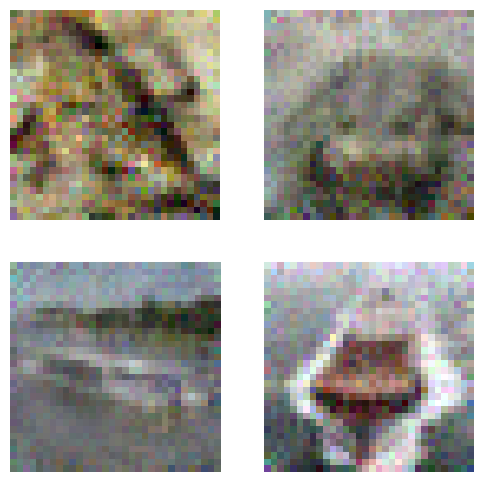

In [17]:
user.plot(reconstructed_user_data)

### Notes:
* Label recovery works reasonably well in this example. Especially as labels are unique in the default settings.
* The interesting part here is not that most images are unrecognizable (they are), but that a few select images do get reconstructed very well.
* Also note that this model is quite large for an experiment on CIFAR-100